In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from typing import List, Tuple


class FactorModel(nn.Module):
    def __init__(self, N: int, K: List[int], d: int):
        super(FactorModel, self).__init__()
        self.N = N  # Number of questions
        self.K = K  # List of number of categorical answers for each question
        self.d = d  # Latent dimension
        self.W = nn.ModuleList([nn.Linear(d, K[i] - 1, bias=False) for i in range(N)])
        self.biases = nn.ParameterList(
            [nn.Parameter(torch.randn(K[i] - 1)) for i in range(N)]
        )

    def forward(self, v: torch.Tensor) -> List[torch.Tensor]:
        logits = [self.W[n](v) + self.biases[n] for n in range(self.N)]
        # Append zero logits for the last category to each question's logits
        logits = [
            torch.cat((logit, torch.zeros(logit.size(0), 1).to(logit.device)), dim=1)
            for logit in logits
        ]
        return logits

    def predict_proba(self, v: torch.Tensor) -> List[torch.Tensor]:
        logits = self.forward(v)  # List of logits for each question
        probabilities = [torch.softmax(logit, dim=-1) for logit in logits]
        return probabilities


def loss_function(
    model: FactorModel,
    v: torch.Tensor,
    answers: torch.Tensor,
    lambda1: float,
    lambda2: float,
) -> torch.Tensor:

    criterion = nn.NLLLoss(reduction="sum")
    logits = model.forward(v)

    total_loss = 0
    for n in range(model.N):
        log_probs = nn.functional.log_softmax(logits[n], dim=1)
        total_loss += criterion(log_probs, answers[:, n])
    nll_loss = total_loss.clone()
    # L2 Regularization
    l2_reg = sum(torch.norm(W.weight, 2) ** 2 for W in model.W)
    total_loss += lambda1 * l2_reg
    total_loss += lambda2 * torch.norm(v, 2) ** 2
    return total_loss, nll_loss


def train_model(
    model: FactorModel,
    answers: torch.Tensor,
    epochs: int = 1000,
    lr: float = 0.01,
    lambda1: float = 0.01,
    lambda2: float = 0.01,
) -> Tuple[FactorModel, torch.Tensor]:

    v = torch.randn(len(answers), model.d, requires_grad=True)

    # optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.Adam(list(model.parameters()) + [v], lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, nllloss = loss_function(model, v, answers, lambda1, lambda2)
        loss.backward()
        optimizer.step()
        # if epoch % 100 == 0:
        # print(f"Epoch {epoch}, Loss: {loss.item()}, nll_loss: {nllloss.item()}")
    print(
        f"d: {model.d}, Epoch {epoch}, Loss: {loss.item()}, nll_loss: {nllloss.item()}"
    )
    return model, v

In [2]:
import json

with open("formated_output_questions_v3.json") as f:
    data = json.load(f)
Q = data.values()
K = []
for q in Q:
    choice = q["choices"].values()
    K.append(len(choice))
print(K)

[5, 5, 5, 5, 5, 5, 5, 5]


In [3]:
# get the file name that starts with "QnA"
import os
import re

file_list = os.listdir(".")
file_list.sort()
file_list = [f for f in file_list if re.match(r"^v3_auto", f)]
# save the file list to csv file:
import pandas as pd

df = pd.DataFrame(file_list, columns=["file_name"])
df.to_csv("auto_QnA_file_list.csv", index=False)
file_list

['v3_auto_QnA_summary_Russo_Ukrainian_War_eng.json',
 'v3_auto_QnA_summary_Russo_Ukrainian_War_zho.json']

In [4]:
import json
import numpy as np


def extract_answers(file):
    with open(file) as f:
        data = json.load(f)

    # Initialize a list to store the extracted values
    answers = []

    # Iterate through the JSON objects to extract `post_LLM_answer`
    for item in data:

        if "answers" in item:
            # get the value under the key `answers`
            answer = item["answers"]
            answers.append(list(answer.values()))
    for a in answers:
        print(a)
    # convert the list of extracted values to a numpy array
    answers = np.array(answers, dtype=object)
    answers = np.where(answers == "A", 0, answers)
    answers = np.where(answers == "B", 1, answers)
    answers = np.where(answers == "C", 2, answers)
    answers = np.where(answers == "D", 3, answers)
    answers = np.where(answers == "E", 4, answers)
    # answers = np.where(answers == ".", 0, answers)
    # find the answer that is "."
    # idx = np.where(answers == ".")
    # idx = list(zip(*idx))
    answers = answers.astype(int)
    return answers

In [5]:
answers = []
for file in file_list:
    answer = extract_answers(file)
    answers.append(answer)
answers = np.array(answers)

# reshape answers to 600,80
answers = answers.reshape(200, len(K))
answers.max()

['A', 'D', 'C', 'E', 'C', 'A', 'B', 'B']
['A', 'B', 'B', 'E', 'C', 'D', 'B', 'B']
['A', 'B', 'A', 'B', 'B', 'A', 'C', 'A']
['A', 'B', 'A', 'B', 'B', 'A', 'B', 'A']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['E', 'E', 'B', 'B', 'B', 'E', 'A', 'E']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['E', 'E', 'E', 'C', 'E', 'E', 'E', 'E']
['B', 'B', 'B', 'B', 'B', 'D', 'A', 'C']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['B', 'B', 'B', 'B', 'B', 'D', 'A', 'C']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['E', 'A', 'E', 'E', 'D', 'E', 'D', 'D']
['B', 'D', 'B', 'B', 'C', 'B', 'B', 'C']
['B', 'B', 'B', 'B', 'B', 'D', 'A', 'C']
['B', 'B', 'B', 'D', 'D', 'D', 'D', 'C']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['B', 'B', 'B', 'B', 'B', 'A', 'A', 'C']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['B', 'C', 'C', 

4

In [6]:
print(K)

[5, 5, 5, 5, 5, 5, 5, 5]


In [7]:
ans_max = list(answers.max(axis=0) + 1)
for i in range(len(ans_max)):
    if ans_max[i] > K[i]:
        print(i + 1, ans_max[i], K[i])

In [8]:
import torch

answers = torch.tensor(answers, dtype=torch.long)

In [9]:
N = len(K)  # Number of questions

M = answers.shape[0]  # Number of articles

In [10]:
N, M

(8, 200)

In [11]:
epo = 10000

# for d in [3] + list(range(5, 41, 5)):

for d in [4, 3]:
    model = FactorModel(N, K, d)
    trained_model, v = train_model(
        model, answers, epochs=epo, lr=0.01, lambda1=0.01, lambda2=0.01
    )
    # Extract the latent vectors v
    latent_vectors = v.detach().numpy()
    # save the latent vectors to csv file
    np.savetxt(
        f"v3_latent_vectors_{d}.csv",
        latent_vectors,
        delimiter=",",
    )

/Users/minlingzhou/miniconda3/envs/my-env/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


d: 4, Epoch 9999, Loss: 88.70305633544922, nll_loss: 28.26443862915039
d: 3, Epoch 9999, Loss: 241.5360107421875, nll_loss: 182.69998168945312


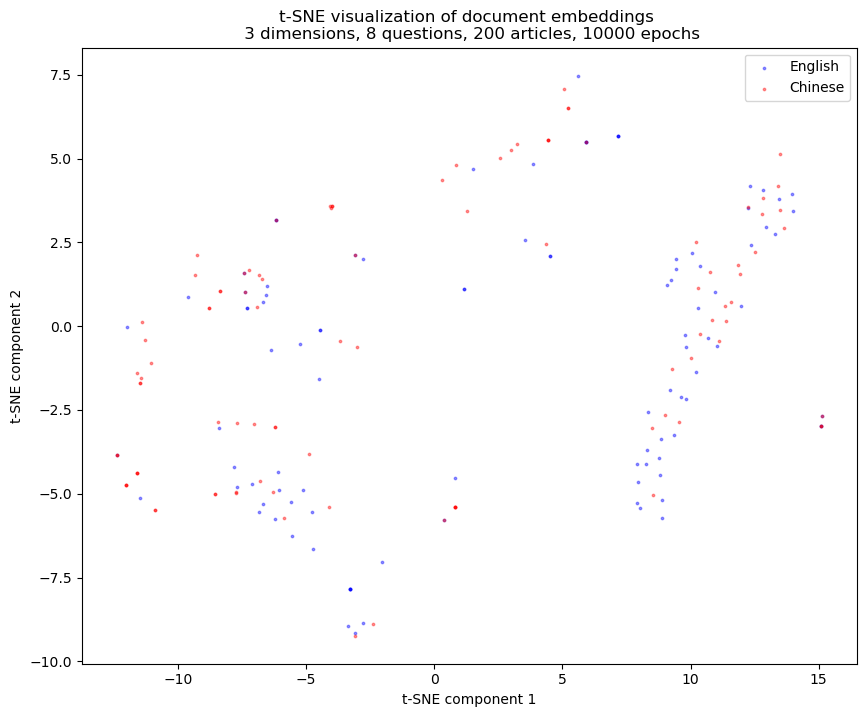

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Normalize the latent vectors
# scaler = StandardScaler()
# latent_vectors_normalized = scaler.fit_transform(latent_vectors)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)

v_2d = tsne.fit_transform(latent_vectors)

# Plot the 2D embeddings with the inedx of each point
plt.figure(figsize=(10, 8))

for index, (x, y) in enumerate(v_2d):
    if index >= 100:
        plt.scatter(
            x, y, alpha=0.4, color="red", s=3, label="Chinese" if index == 100 else ""
        )
    else:
        plt.scatter(
            x, y, alpha=0.4, color="blue", s=3, label="English" if index == 0 else ""
        )
    # plt.text(x, y, str(index), fontsize=9, color="blue")

plt.title(
    f"t-SNE visualization of document embeddings \n {d} dimensions, {N} questions, {M} articles, {epo} epochs"
)

plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.legend()
plt.show()

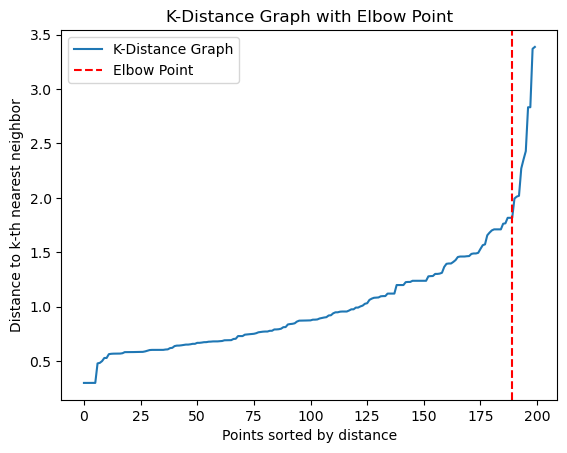

Elbow point (knee) is at index: 189, distance: 1.8160292758764358


In [13]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# Compute k-nearest neighbors (k is set to min_samples)
min_samples = 5
neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(v_2d)
distances, indices = nbrs.kneighbors(v_2d)

# Sort distances to the k-th nearest neighbor
distances = np.sort(distances[:, min_samples - 1])

x = np.arange(len(distances))
kneedle = KneeLocator(x, distances, curve="convex", direction="increasing")

# Plot the results
plt.plot(x, distances, label="K-Distance Graph")
plt.axvline(x=kneedle.knee, color="r", linestyle="--", label="Elbow Point")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to k-th nearest neighbor")
plt.title("K-Distance Graph with Elbow Point")
plt.legend()
plt.show()

# Print the knee point
print(
    f"Elbow point (knee) is at index: {kneedle.knee}, distance: {distances[kneedle.knee]}"
)

In [14]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=distances[kneedle.knee], min_samples=min_samples)
labels = dbscan.fit_predict(v_2d)

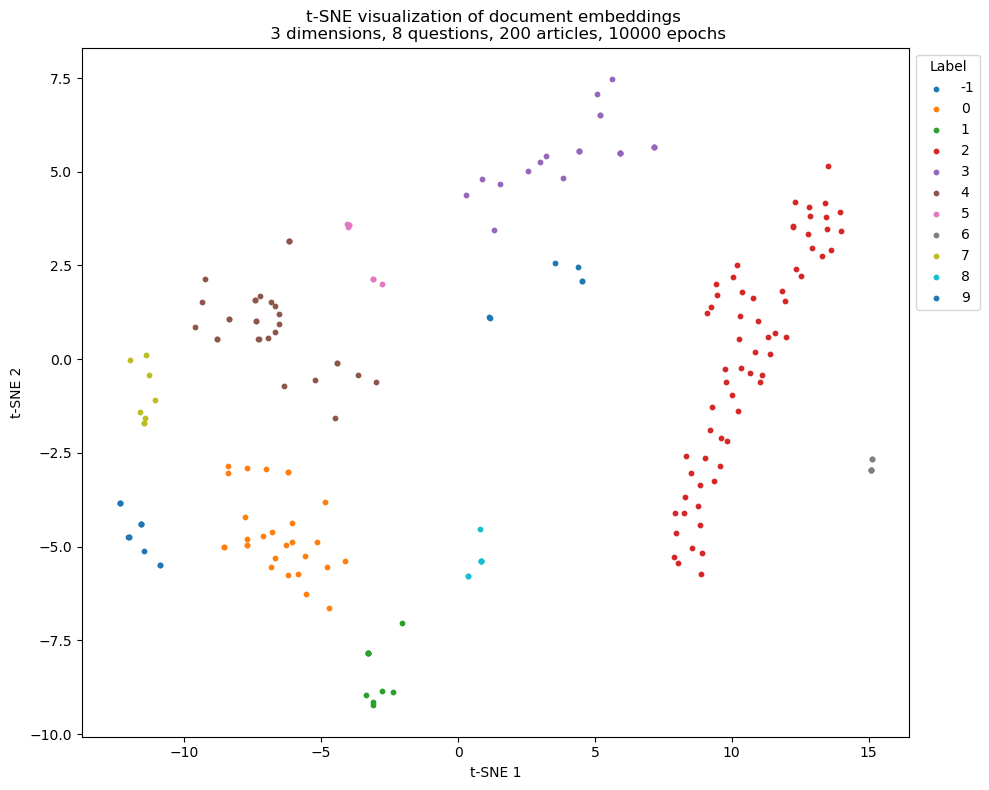

In [15]:
plt.figure(figsize=(10, 8))
for y in np.unique(labels):
    plt.scatter(
        v_2d[labels == y, 0], v_2d[labels == y, 1], label=f"{y}", s=10, marker="o"
    )

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title(
    f"t-SNE visualization of document embeddings \n {d} dimensions, {N} questions, {M} articles, {epo} epochs"
)
plt.legend(title="Label", loc="upper left", bbox_to_anchor=(1, 1), ncol=1)
plt.tight_layout()
plt.show()

In [16]:
# print the answers that has the same label
for i in range(labels.max() + 1):
    print(f"Label {i}")
    print(answers[labels == i])

Label 0
tensor([[0, 3, 2, 4, 2, 0, 1, 1],
        [0, 1, 1, 4, 2, 3, 1, 1],
        [4, 4, 1, 1, 1, 4, 0, 4],
        [1, 3, 1, 1, 2, 1, 1, 2],
        [1, 1, 1, 1, 1, 0, 0, 2],
        [0, 1, 1, 1, 1, 4, 2, 3],
        [4, 4, 1, 3, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 4, 1, 2],
        [1, 1, 1, 1, 1, 4, 0, 0],
        [1, 3, 1, 3, 2, 1, 0, 1],
        [0, 1, 0, 1, 1, 3, 1, 1],
        [1, 3, 1, 1, 1, 3, 1, 1],
        [4, 4, 1, 3, 0, 4, 0, 0],
        [1, 1, 1, 3, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 3, 0, 4, 0, 3],
        [1, 1, 1, 1, 1, 4, 0, 0],
        [3, 1, 1, 3, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0],
        [3, 4, 1, 3, 0, 4, 0, 3],
        [1, 1, 1, 3, 0, 4, 0, 0],
        [0, 1, 1, 1, 1, 3, 1, 1],
        [1, 1, 1, 1, 1, 4, 0, 0],
        [1, 4, 1, 3, 0, 4, 0, 3],
        [3, 4, 1, 3, 0, 4, 0, 3],
        [3, 4, 1, 3, 0, 4, 4, 4],
        [4, 4, 1, 1, 1, 4, 4, 4],
        [3, 1, 1, 1, 1, 0, 0, 3]])
Label 1
tensor([[0, 1, 0, 1, 1, 0, 2, 0

In [17]:
# count the number of 0,1,2,3,4 in each question
for i in range(answers.shape[1]):
    print(f"Question {i+1}")
    print(np.unique(answers[:, i], return_counts=True))

Question 1
(array([0, 1, 2, 3, 4]), array([ 24,  59,   3,  10, 104]))
Question 2
(array([0, 1, 2, 3, 4]), array([ 12,  70,  10,   4, 104]))
Question 3
(array([0, 1, 2, 3, 4]), array([ 9, 80, 14,  1, 96]))
Question 4
(array([0, 1, 2, 3, 4]), array([13, 65,  7, 38, 77]))
Question 5
(array([0, 1, 2, 3, 4]), array([13, 73,  6, 24, 84]))
Question 6
(array([0, 1, 2, 3, 4]), array([ 18,  15,   2,  63, 102]))
Question 7
(array([0, 1, 2, 3, 4]), array([61, 17,  5, 21, 96]))
Question 8
(array([0, 1, 2, 3, 4]), array([30, 11, 39, 23, 97]))


In [18]:
# print the index of the articles that has the same label
for i in range(labels.max() + 1):
    print(f"Label {i}")
    print(np.where(labels == i)[0])

Label 0
[  0   1   5  16  20  28  53  56  62  63  65  73  88  90 106 110 111 124
 133 140 155 161 165 171 173 174 188 190]
Label 1
[  2   3  25  29  46  48  91  96 113 143]
Label 2
[  4   6   7   8  11  12  14  19  21  22  23  40  41  43  44  47  52  55
  57  58  59  64  66  67  70  71  75  76  77  80  81  83  85  89  94  95
  97  98  99 101 108 122 132 136 137 138 144 150 156 163 167 172 177 181
 182 183 184 186 187 189 194 196 198 199]
Label 3
[  9  15  39  49  50  54  60  86  93 100 102 109 115 123 127 141 164 175
 176 180 195 197]
Label 4
[ 10  13  17  18  26  27  30  31  32  33  45  69  74  79  87 103 104 105
 107 114 119 129 130 131 145 147 148 153 157 185]
Label 5
[ 24  37 120 151 152 160 166]
Label 6
[ 35  82  92 126 135 149]
Label 7
[ 38 121 139 154 168 170 178 179]
Label 8
[ 42  51 125 128 134 146 169]
Label 9
[ 61  68 112 116 117 118 158 159 162 191 192 193]


In [19]:
np.savetxt("answers_v3.csv", answers, delimiter=",")

In [20]:
# save the label as interger to csv file
labels = labels.astype(int)
np.savetxt("labels_v3.csv", labels, delimiter=",")